In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib, copy
from glob import glob
import pickle
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.electromagnetic import FreeVectorPotential, CavityVectorPotential

from matter.atoms import AtomsInBox
from calculator.calculator import Calculator

from utilities.etc import categorizing_result

import animation as an
import analyze_tools.utils as atu
from analyze_tools.monte_carlo import get_colliding_time

from simulation.single import single_collision_simulation
import utilities.reduced_parameter as red
from utilities.etc import moving_average

ROOT = os.path.expanduser('~/OneDrive - Emory/Research Data/mm_polariton/pickle_jar/')

#ROOT = os.path.expanduser('~/OneDrive - Emory/Research data/mm_polariton/pickle_jar')
#assert os.path.isdir(ROOT)

Epsilon (erg) 1.6538969109051514e-14
Reduced epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.3825301204819278 ; 1.9116465863453815
CGS epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.6538969109051514e-14 ; 2.286562295498387e-14 ; 3.161666383899004e-14
######################
Length multiple - Sigma (cm) 3.41e-08
Reduced sigma (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.095307917888563 ; 1.190615835777126
######################
Mass multiples (g) 6.633521465546083e-23
Reduced Mass (Ar, Xe): 1.0 ; 3.286597576849905
######################
Dipole unit multiple (statC . cm) 8.09814943451058e-19
Reduced dipole parameter:
mu0 =  0.08920009870622121
a =  7.8952761266316935
d0 =  1.1018059229945159
CGS dipole parameter:
mu0 =  7.223557288960733e-20
a = 2.32E+08
d0 =  3.757158197411299e-08
######################
Time 2.159594587679023e-12
Velocity multiple (cm/s) 15790.00067630667
######################
c:  1899936.5874009002
Epsilon parameters matrix 
[[1.         1.38253012]
 [1.38253012 1.91164659]]
Sigma parameters matrix 
[[1. 

In [2]:
#
# DEFINING FUNCTION
## WARNING: NEXT CELL WILL RUN SIMULATIONS
#


Lxy = 3e7; Lz = 3e3
def get_ArXePair(
    d_arxe, v_ar = 0, h = 0, n_pairs = 1, Lxy=Lxy, Lz=Lz, random_origin = False):
    """
    """
    atoms = AtomsInBox(
        Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
        mass_dict = red.mass_dict)

    v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

    for i in range(n_pairs):
        if i == 0 and not random_origin:
            r0 = np.zeros(3)
        elif random_origin:
            r0 = np.hstack(
                [
                    np.random.uniform(-Lxy/2+100, Lxy/2-100, size = 2), 
                    #np.zeros(2),
                    np.random.uniform(-Lz/2+100, Lz/2-100)]
            )
        atoms.add(
                elements = ["Ar"],
                r = np.array([[0.0, h, -d_arxe/2]]) + r0,
                r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
                )
        
        atoms.add(
                elements = ["Xe"],
                r = np.array([[0.0,0.0,d_arxe/2]]) + r0,
                r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
                )
    
    idxAr = atoms.element_idx(element = "Ar")
    idxXe = atoms.element_idx(element = "Xe")
    epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)
    
    # calculator to the atoms object
    atoms.add_calculator(
        calculator_class = Calculator,
        calculator_kwargs = {
            "epsilon": epsilon_mat, "sigma" : sigma_mat, 
            "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
            "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
        })
    
    atoms.update_distance()
    
    return atoms

def get_field(coup_str, amplitude, T = None, mode = False, Lxy = Lxy, Lz = Lz, field = 'cavity'):
    if mode == 'multi':
        k_vector_int = np.array(
            [[i,0,0] for i in range(1,100)]
            ,dtype=np.float64)
    elif isinstance(mode, int):
        k_vector_int = np.array([[mode,0,0]])
    elif isinstance(mode, list):
        k_vector_int = np.array(
            [[i,0,0] for i in mode], 
            dtype = np.float64)
    else:
        raise Exception('Mode have to be either "multi" or an integer!')
    
    if field == 'cavity':
        VectorPotentialClass = CavityVectorPotential
    elif field == 'free':
        VectorPotentialClass = FreeVectorPotential
    
    Afield = VectorPotentialClass(
            k_vector_int = k_vector_int, amplitude = amplitude,
            Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = coup_str, T = T / red.temp
            )

    return Afield

def get_radprofile(rd, windows = 10):
    Afield = rd['field']
    
    rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "ev") 
    omega = red.convert_wavenumber(Afield.k_val)
    omega_profile, final_rad_profile = atu.profiling_rad(omega, rad_energy)
    
    sorted_idx = np.argsort(omega_profile)

    if windows == 0:
        omega_profile = np.array(omega_profile)[sorted_idx] 
        final_rad_profile = np.array(final_rad_profile)[sorted_idx]
    else:
        omega_profile, final_rad_profile = moving_average(
            np.array(omega_profile)[sorted_idx], 
            np.array(final_rad_profile)[sorted_idx], windows)

    return omega_profile, final_rad_profile

In [ ]:
# 
# CALCULATING SPECTRA
# Run simulation of head on collision coupled to FREE field 
# at various total energy as temperature 
# 

result_dict = {}
velocity_dict = {}

M_Xe = red.mass_dict['Xe']

for T in tqdm.tqdm(list(range(25,860,25))):
    
    vt = np.sqrt((T * red.boltzmann / red.epsilon) )
    atoms = get_ArXePair(d_arxe = 6, h = 0.0 , v_ar = vt, n_pairs = 1)
    
    field = get_field(amplitude = 'zero', mode = list(range(1,300)), coup_str = 1, Lz = Lxy, field = 'free' , T = T)
        
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)

    result_dict.update({T : rd})
    velocity_dict.update({T : (vt, vt / np.sqrt(M_Xe))})

In [ ]:
#
# PLOTTING SPECTRA
#

fig,ax = plt.subplots(2, figsize = (6,8))

total = 0
total100 = 0

prob_list292 = []
prob_list100 = []

for T in result_dict.keys():
    prob_list292.append(T * np.exp(- T / 292))
    prob_list100.append(T * np.exp(- T / 100))

prob_list292 = np.array(prob_list292)
prob_list292 = prob_list292 / np.sum(prob_list292)
prob_list100 = np.array(prob_list100)
prob_list100 = prob_list100 / np.sum(prob_list100)

for i, (T,rd) in enumerate(result_dict.items()):
    
    omega_profile, final_rad_profile = atu.field_spectra(
        rd, 
        convert_function = {'energy':red.convert_energy, 'wavenumber':red.convert_wavenumber},
        mode = 'std'
    )
    final_rad_profile *= 1e25
    total += final_rad_profile * prob_list292[i]
    total100 += final_rad_profile * prob_list100[i]

    if T % 100 == 0:
        ax[0].plot(
            omega_profile, final_rad_profile, label = 'T = {} K'.format(T), 
            linestyle = 'dashdot' if i >= 35 else None)

ax[1].plot(omega_profile, total, label = 'Scaled total spectrum')
  
tax = ax[1].twinx()
exp_data = pd.read_csv('data/plot-data.csv')
tax.scatter(
    exp_data.loc[:,'x'],
    exp_data.loc[:,' y'],
    s = 5, alpha = 0.5, c = 'black'
)
ax[1].scatter([],[], c = 'black', label = 'Exp. @ 292K')

ax[0].set_ylabel(r"Calculated EM field energy $(10^{-25} eV)$")
ax[1].set_ylabel(r"Sum of scaled EM field energy $(10^{-25} eV)$")
ax[1].set_xlabel(r"Wavenumber $(cm^{-1})$")

tax.set_ylabel(r'Exp. absorption $(10^{-6} cm^{-1} amagat^{-2})$')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1].annotate('(b)',xy = (0.9,0.7), xycoords = 'axes fraction', fontsize = 'x-large')

ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=4)
ax[1].legend()

#"""
ax[0].set_ylim(-0.00, 0.72)
ax[1].set_ylim(-0.00, 0.44)
tax.set_ylim(-0.00,2.55)
#"""
ax[0].set_xlim(0.0, 250)
ax[1].set_xlim(0.0, 250)

fig.savefig('figure/manuscript/free_spectrum_singleT.jpeg',dpi = 600, bbox_inches = 'tight')

In [ ]:
# 
# CALCULATING SPECTRA
# Run simulation of head on collision coupled to CAVITY field 
# at various total energy as temperature 
# 
all_result_dict = {}

for coup_str in [10, 20]:
    print(coup_str)
    result_dict = {}
    velocity_dict = {}
    
    M_Xe = red.mass_dict['Xe']
    
    for T in tqdm.tqdm(np.arange(10, 850, 10)):
        
        vt = np.sqrt((T * red.boltzmann / red.epsilon) )
        atoms = get_ArXePair(d_arxe = 6, h = 0.0 , v_ar = vt, n_pairs = 1)
        
        field = get_field(amplitude = 'zero', mode = list(range(1,300)), 
                          coup_str = coup_str * Lxy, Lz = Lz, field = 'cavity' , T = T)
            
        t, rd = single_collision_simulation(
            0, h = 1e-2, atoms = atoms, field = field, 
            max_steps = 5000, verbose = False)
    
        result_dict.update({T : rd})
        velocity_dict.update({T : (vt, vt / np.sqrt(M_Xe))})
        
    all_result_dict.update({coup_str : (result_dict, velocity_dict) })

In [ ]:
save_path = 'pickle_jar/single_collision_zero_cavity'

prompt = input('Do you want to save to path? y/(n)')
if prompt is not 'y': raise Exception

with open(save_path + '/spectra.pkl','wb') as handle:
    pickle.dump(all_result_dict, handle)

In [ ]:
#
# PLOTTING SPECTRA
#
save_path = 'pickle_jar/single_collision_boltzmann_cavity'
with open(save_path + '/spectra.pkl','rb') as handle:
    all_result_dict = pickle.load(handle)

fig,ax = plt.subplots(2, figsize = (6,8) )

for i , (coup_str, foo) in enumerate(all_result_dict.items()):
    
    result_dict, velocity_dict = foo
    
    total100_ = 0
    prob_list100_ = []
    
    for T in result_dict.keys():
        prob_list100_.append(T * np.exp(- T / 100))
    
    for j, (T,rd) in enumerate(result_dict.items()):
        
        omega_profile, final_rad_profile = atu.field_spectra(
            rd, convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'abs'
        )
        omega_profile, final_rad_profile = moving_average(omega_profile, final_rad_profile, w = 10)
        final_rad_profile *= 1e2
        total100_ += final_rad_profile * prob_list100_[j]
    
    ax[i].plot(omega_profile, total100_, label = 'Scaled total spectrum in free space')
    ax[i].plot([], [], linestyle = 'dotted', color = 'r', label = 'Scaled total spectrum in the cavity')
    ax[i].set_xlim(0,200)
      
    tax = ax[i].twinx()
    tax.plot(omega_profile, total100, linestyle = 'dotted', color = 'r')

    """
    if i == 0:
        ax[i].set_ylim(0,5.5) # coup_str = 10 L
        tax.set_ylim(0,0.7) # coup_str = 10 L
    elif i == 1:
        ax[i].set_ylim(0,18) # coup_str = 10 L
        tax.set_ylim(0,0.9) # coup_str = 10 L
    elif i == 2:
        ax[i].set_ylim(0,35) # coup_str = 10 L
        tax.set_ylim(0,0.9) # coup_str = 10 L
    """
    
    ax[i].set_ylabel(r"Sum of scaled cavity field energy $(10^{-2} eV)$")
    
    tax.set_ylabel(r"Sum of scaled free field energy $(10^{-25} eV)$")
    
ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=1)

ax[0].annotate(r'$\gamma = 10L$',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
ax[1].annotate(r'$\gamma = 15L$',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
#ax[2].annotate(r'$\gamma = 20L$',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[2].set_xlabel(r"Wavenumber $(cm^{-1})$")
fig.savefig('figure/manuscript/cavity_spectrum_singleT.jpeg',dpi = 600, bbox_inches = 'tight')

In [4]:
#
# Record (trajectory @ 40K, highest temperature that Ar-Xe complex form, previous temperature)
#

np.random.seed(20)

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = [0.0]
Tlist = list(np.arange(10, 155, 1))

cavity_init = 'boltzmann'
save_path = 'pickle_jar/single_collision_{}_cavity'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

result_dict = {}
for ct in [20, 10]:
    result_dict_ = {}
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)
        T_break = None

        foo = {}
        
        for T in Tlist:
            print("{}/{}".format(T, Tlist[-1]))
            collide_time_list = []
            
            for i in tqdm.tqdm(range(100)):

                vt = np.sqrt((T * red.boltzmann / red.epsilon) )
                # T = K_Ar + K_Xe = 2K_Ar = m_Ar v_Ar^2 (equal kinetic energy of Argon and Xenon)
                atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1, random_origin = True)
                
                field = get_field(
                    amplitude = cavity_init, T = T,
                    mode = list(range(1,260)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
                )
                    
                t, rd = single_collision_simulation(
                    0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                    max_steps = 10000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

                collide_time = get_colliding_time(rd['atoms'], 0)
                
                collide_time_list += collide_time

            #foo.update({T:rd})
            foo.update({T:collide_time_list})
            
        result_dict_.update({h : foo})
    result_dict.update({ct : result_dict_})

with open(save_path + '/collide_time_dict100.pkl','wb') as handle:
    pickle.dump(result_dict, handle)
            

Load file?(Y)/N N


pickle_jar/single_collision_boltzmann_cavity
h =  0.0  coupling strength =  20
10/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [54:21<00:00, 32.62s/it]


11/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [53:08<00:00, 31.89s/it]


12/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [50:37<00:00, 30.37s/it]


13/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [53:16<00:00, 31.96s/it]


14/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [48:42<00:00, 29.23s/it]


15/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [49:25<00:00, 29.66s/it]


16/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [49:21<00:00, 29.62s/it]


17/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:28<00:00, 28.48s/it]


18/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:13<00:00, 28.33s/it]


19/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [46:45<00:00, 28.06s/it]


20/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [46:41<00:00, 28.02s/it]


21/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [44:00<00:00, 26.41s/it]


22/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [43:20<00:00, 26.00s/it]


23/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [41:24<00:00, 24.84s/it]


24/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [43:35<00:00, 26.16s/it]


25/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [42:04<00:00, 25.24s/it]


26/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [41:28<00:00, 24.88s/it]


27/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [37:48<00:00, 22.68s/it]


28/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [41:52<00:00, 25.13s/it]


29/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [37:32<00:00, 22.53s/it]


30/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [35:46<00:00, 21.47s/it]


31/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [34:03<00:00, 20.44s/it]


32/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [31:07<00:00, 18.68s/it]


33/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:54<00:00, 18.54s/it]


34/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:20<00:00, 18.21s/it]


35/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [28:18<00:00, 16.98s/it]


36/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [24:59<00:00, 15.00s/it]


37/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [27:48<00:00, 16.69s/it]


38/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [25:15<00:00, 15.16s/it]


39/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [23:34<00:00, 14.14s/it]


40/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:26<00:00, 17.66s/it]


41/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [24:40<00:00, 14.80s/it]


42/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [24:37<00:00, 14.77s/it]


43/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [23:15<00:00, 13.96s/it]


44/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:23<00:00, 12.24s/it]


45/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [22:51<00:00, 13.72s/it]


46/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:44<00:00, 12.44s/it]


47/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [21:23<00:00, 12.83s/it]


48/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [17:41<00:00, 10.61s/it]


49/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:53<00:00, 11.34s/it]


50/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:52<00:00, 11.93s/it]


51/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:27<00:00, 11.67s/it]


52/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:32<00:00,  9.32s/it]


53/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:42<00:00, 10.03s/it]


54/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:44<00:00, 11.24s/it]


55/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:36<00:00,  9.97s/it]


56/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:13<00:00,  9.74s/it]


57/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:14<00:00,  7.95s/it]


58/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:53<00:00,  8.93s/it]


59/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:36<00:00,  8.77s/it]


60/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:37<00:00,  8.17s/it]


61/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:58<00:00,  8.39s/it]


62/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:06<00:00,  7.86s/it]


63/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:58<00:00,  8.39s/it]


64/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:56<00:00,  8.37s/it]


65/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:40<00:00,  8.81s/it]


66/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:45<00:00,  8.25s/it]


67/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:50<00:00,  7.71s/it]


68/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:28<00:00,  6.89s/it]


69/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:02<00:00,  7.82s/it]


70/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:48<00:00,  7.08s/it]


71/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:37<00:00,  5.78s/it]


72/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:34<00:00,  6.95s/it]


73/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:02<00:00,  6.03s/it]


74/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:19<00:00,  6.19s/it]


75/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:52<00:00,  7.12s/it]


76/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:05<00:00,  7.85s/it]


77/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:41<00:00,  5.82s/it]


78/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:27<00:00,  5.68s/it]


79/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:08<00:00,  5.48s/it]


80/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:44<00:00,  5.84s/it]


81/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:01<00:00,  6.01s/it]


82/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:20<00:00,  5.60s/it]


83/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:27<00:00,  5.68s/it]


84/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:45<00:00,  5.85s/it]


85/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:54<00:00,  5.35s/it]


86/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:20<00:00,  5.61s/it]


87/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:09<00:00,  5.50s/it]


88/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:28<00:00,  5.69s/it]


89/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:09<00:00,  4.89s/it]


90/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:02<00:00,  5.42s/it]


91/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:43<00:00,  5.24s/it]


92/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:23<00:00,  5.64s/it]


93/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:55<00:00,  4.76s/it]


94/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:25<00:00,  5.05s/it]


95/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:13<00:00,  4.94s/it]


96/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:39<00:00,  5.19s/it]


97/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:33<00:00,  5.13s/it]


98/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:32<00:00,  5.12s/it]


99/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:55<00:00,  5.36s/it]


100/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:34<00:00,  4.55s/it]


101/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:17<00:00,  4.98s/it]


102/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:26<00:00,  4.46s/it]


103/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:01<00:00,  5.42s/it]


104/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:22<00:00,  4.43s/it]


105/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:04<00:00,  4.85s/it]


106/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:22<00:00,  4.43s/it]


107/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:33<00:00,  4.53s/it]


108/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:22<00:00,  5.03s/it]


109/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:16<00:00,  4.36s/it]


110/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:21<00:00,  4.42s/it]


111/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:25<00:00,  4.45s/it]


112/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:00<00:00,  4.80s/it]


113/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:41<00:00,  4.02s/it]


114/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:42<00:00,  4.02s/it]


115/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:56<00:00,  4.17s/it]


116/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.55s/it]


117/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:49<00:00,  4.09s/it]


118/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:41<00:00,  4.01s/it]


119/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:27<00:00,  4.48s/it]


120/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:26<00:00,  4.47s/it]


121/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:13<00:00,  3.74s/it]


122/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:23<00:00,  4.44s/it]


123/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:40<00:00,  4.00s/it]


124/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:47<00:00,  4.08s/it]


125/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:20<00:00,  3.81s/it]


126/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:03<00:00,  4.24s/it]


127/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:44<00:00,  3.45s/it]


128/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:52<00:00,  4.12s/it]


129/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:21<00:00,  3.82s/it]


130/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:39<00:00,  4.00s/it]


131/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:58<00:00,  4.18s/it]


132/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:54<00:00,  4.15s/it]


133/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:14<00:00,  3.75s/it]


134/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:47<00:00,  4.07s/it]


135/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:57<00:00,  3.58s/it]


136/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:10<00:00,  3.70s/it]


137/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:34<00:00,  3.35s/it]


138/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:11<00:00,  3.72s/it]


139/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:01<00:00,  3.61s/it]


140/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:03<00:00,  3.63s/it]


141/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


142/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:27<00:00,  3.88s/it]


143/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:45<00:00,  3.46s/it]


144/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:59<00:00,  3.60s/it]


145/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:46<00:00,  4.06s/it]


146/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:20<00:00,  3.20s/it]


147/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:38<00:00,  3.99s/it]


148/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:33<00:00,  3.34s/it]


149/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:37<00:00,  3.37s/it]


150/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:04<00:00,  3.65s/it]


151/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:25<00:00,  3.25s/it]


152/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:25<00:00,  3.26s/it]


153/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:14<00:00,  3.14s/it]


154/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:42<00:00,  3.42s/it]


h =  0.0  coupling strength =  10
10/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [37:11<00:00, 22.31s/it]


11/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [39:03<00:00, 23.44s/it]


12/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [34:11<00:00, 20.51s/it]


13/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [37:21<00:00, 22.42s/it]


14/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [37:35<00:00, 22.55s/it]


15/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [31:59<00:00, 19.19s/it]


16/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [33:49<00:00, 20.30s/it]


17/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [31:47<00:00, 19.08s/it]


18/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [31:08<00:00, 18.69s/it]


19/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:53<00:00, 17.94s/it]


20/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [23:05<00:00, 13.85s/it]


21/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [27:40<00:00, 16.61s/it]


22/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [26:13<00:00, 15.73s/it]


23/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [25:47<00:00, 15.48s/it]


24/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:07<00:00, 18.07s/it]


25/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:20<00:00, 12.21s/it]


26/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:12<00:00, 11.53s/it]


27/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:34<00:00, 11.74s/it]


28/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:09<00:00, 11.50s/it]


29/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:28<00:00, 11.08s/it]


30/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [22:49<00:00, 13.69s/it]


31/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [21:15<00:00, 12.75s/it]


32/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [21:54<00:00, 13.15s/it]


33/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [22:08<00:00, 13.29s/it]


34/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:18<00:00, 12.19s/it]


35/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:02<00:00, 10.82s/it]


36/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:31<00:00,  9.91s/it]


37/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [17:19<00:00, 10.40s/it]


38/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:45<00:00,  7.66s/it]


39/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:06<00:00,  9.07s/it]


40/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [17:36<00:00, 10.56s/it]


41/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:59<00:00,  8.39s/it]


42/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:03<00:00,  9.63s/it]


43/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:53<00:00,  8.33s/it]


44/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:39<00:00,  8.80s/it]


45/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:29<00:00,  9.29s/it]


46/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:05<00:00,  9.05s/it]


47/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:34<00:00,  6.94s/it]


48/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:43<00:00,  8.83s/it]


49/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:45<00:00,  7.05s/it]


50/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:25<00:00,  8.05s/it]


51/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:09<00:00,  7.89s/it]


52/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:05<00:00,  6.05s/it]


53/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:02<00:00,  6.63s/it]


54/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:01<00:00,  6.62s/it]


55/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:02<00:00,  6.63s/it]


56/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:52<00:00,  6.52s/it]


57/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:21<00:00,  6.81s/it]


58/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:37<00:00,  6.37s/it]


59/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:36<00:00,  6.36s/it]


60/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:58<00:00,  5.99s/it]


61/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:49<00:00,  6.49s/it]


62/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:14<00:00,  7.34s/it]


63/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:19<00:00,  5.59s/it]


64/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:49<00:00,  5.89s/it]


65/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:43<00:00,  7.04s/it]


66/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:20<00:00,  7.41s/it]


67/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:47<00:00,  5.28s/it]


68/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:06<00:00,  6.07s/it]


69/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:56<00:00,  5.37s/it]


70/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:17<00:00,  6.77s/it]


71/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:08<00:00,  5.49s/it]


72/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:30<00:00,  5.10s/it]


73/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:36<00:00,  5.77s/it]


74/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:40<00:00,  5.81s/it]


75/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:30<00:00,  4.50s/it]


76/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:48<00:00,  6.49s/it]


77/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:39<00:00,  4.59s/it]


78/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:53<00:00,  5.34s/it]


79/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:11<00:00,  4.91s/it]


80/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:52<00:00,  4.73s/it]


81/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:27<00:00,  5.07s/it]


82/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:11<00:00,  4.32s/it]


83/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:37<00:00,  5.17s/it]


84/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:14<00:00,  4.94s/it]


85/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:39<00:00,  4.59s/it]


86/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:42<00:00,  4.63s/it]


87/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:28<00:00,  3.88s/it]


88/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:29<00:00,  4.50s/it]


89/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:31<00:00,  5.11s/it]


90/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:25<00:00,  5.06s/it]


91/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:44<00:00,  4.04s/it]


92/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:17<00:00,  4.98s/it]


93/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:10<00:00,  3.71s/it]


94/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:19<00:00,  3.79s/it]


95/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:22<00:00,  4.43s/it]


96/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:49<00:00,  4.09s/it]


97/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:15<00:00,  3.75s/it]


98/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:45<00:00,  4.65s/it]


99/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:07<00:00,  4.27s/it]


100/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:14<00:00,  3.74s/it]


101/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:13<00:00,  4.93s/it]


102/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:10<00:00,  3.71s/it]


103/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:21<00:00,  4.42s/it]


104/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:07<00:00,  4.28s/it]


105/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.52s/it]


106/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:25<00:00,  3.25s/it]


107/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:59<00:00,  3.59s/it]


108/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:25<00:00,  3.25s/it]


109/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:14<00:00,  3.75s/it]


110/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:00<00:00,  3.60s/it]


111/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:13<00:00,  3.74s/it]


112/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:15<00:00,  3.76s/it]


113/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:00<00:00,  3.60s/it]


114/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:04<00:00,  3.65s/it]


115/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:38<00:00,  3.99s/it]


116/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:57<00:00,  3.58s/it]


117/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:22<00:00,  3.22s/it]


118/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:18<00:00,  4.38s/it]


119/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:28<00:00,  3.29s/it]


120/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:44<00:00,  3.45s/it]


121/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:47<00:00,  3.48s/it]


122/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:25<00:00,  3.86s/it]


123/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:06<00:00,  3.66s/it]


124/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:54<00:00,  4.15s/it]


125/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:13<00:00,  3.13s/it]


126/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:23<00:00,  3.23s/it]


127/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:21<00:00,  3.22s/it]


128/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:39<00:00,  3.39s/it]


129/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:38<00:00,  3.98s/it]


130/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.05s/it]


131/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:42<00:00,  2.83s/it]


132/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:41<00:00,  3.42s/it]


133/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.05s/it]


134/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:51<00:00,  2.92s/it]


135/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:03<00:00,  3.04s/it]


136/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:41<00:00,  2.82s/it]


137/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:20<00:00,  3.20s/it]


138/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:37<00:00,  3.38s/it]


139/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:58<00:00,  2.98s/it]


140/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:33<00:00,  3.34s/it]


141/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:43<00:00,  2.84s/it]


142/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.47s/it]


143/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:28<00:00,  2.69s/it]


144/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:22<00:00,  3.22s/it]


145/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:47<00:00,  2.87s/it]


146/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:56<00:00,  2.97s/it]


147/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:40<00:00,  2.80s/it]


148/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:51<00:00,  2.92s/it]


149/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:10<00:00,  3.10s/it]


150/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:22<00:00,  2.62s/it]


151/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:39<00:00,  2.79s/it]


152/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:26<00:00,  2.66s/it]


153/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:22<00:00,  2.62s/it]


154/154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:47<00:00,  2.87s/it]


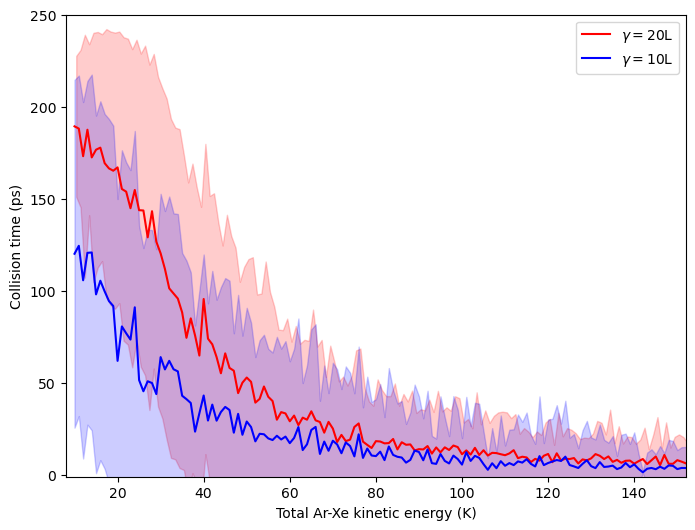

In [12]:
ROOT = 'pickle_jar'
with open(ROOT+'/single_collision_boltzmann_cavity/collide_time_dict100.pkl', 'rb') as handle:
    result_dict = pickle.load(handle)

color_list = ['blue', 'red']
label = {10:"10L", 20:"20L"}

fig,ax = plt.subplots(1, figsize = (8,6))
for i, (coup_str, coup_str_dict) in enumerate(result_dict.items()):
    mean_collide_time = []
    std_collide_time = []
    Tlist = []
    h_dict = coup_str_dict[0.0]
    for t, collide_tlist in h_dict.items():
        Tlist.append(t)
        mean_collide_time.append(np.mean(collide_tlist))
        std_collide_time.append(np.std(collide_tlist))

    mean_collide_time = np.array(mean_collide_time)
    std_collide_time = np.array(std_collide_time)

    if coup_str == 20: i = 1
    elif coup_str == 10: i = 0
    #ax.plot(Tlist, mean_collide_time)
    ax.fill_between(
        np.array(Tlist) + 0.4 * i, 
        mean_collide_time + std_collide_time,
        mean_collide_time - std_collide_time, 
        color = color_list[i],
        alpha = 0.2
    )
    ax.plot(
        np.array(Tlist), mean_collide_time, 
        color = color_list[i],
        label = r'$\gamma = ${}'.format(label[coup_str])
    )
    ax.set_ylim(-1, 250)
    ax.set_xlim(8, 152)

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax.set_ylabel(r'Collision time (ps)')

ax.set_xlabel('Total Ar-Xe kinetic energy (K)')
ax.legend()

fig.savefig('figure/manuscript/boltzmann_collision_time.jpeg', dpi = 600, bbox_inches = 'tight')

In [ ]:
#
# Record (trajectory @ 40K, highest temperature that Ar-Xe complex form, previous temperature)
#

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = [0.0, 0.3, 0.6, 0.9, 1.2]
Tlist = list(np.arange(10, 150, 5))

cavity_init = 'boltzmann'
save_path = 'pickle_jar/single_collision_{}_cavity'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

for ct in [20, 15, 10]:
    result_dict = {}
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)
        T_break = None

        foo = {}
        
        for T in tqdm.tqdm(Tlist[::-1]):

            vt = np.sqrt((T * red.boltzmann / red.epsilon) )
            # T = K_Ar + K_Xe = 2K_Ar = m_Ar v_Ar^2 (equal kinetic energy of Argon and Xenon)
            atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1)
            
            field = get_field(
                amplitude = cavity_init, T = T,
                mode = list(range(1,100)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
            )
                
            t, rd = single_collision_simulation(
                0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                max_steps = 10000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

            foo.update({T:rd})
            
        result_dict.update({h : foo})

    with open(save_path + '/coup_str_{}.pkl'.format(ct),'wb') as handle:
        pickle.dump(result_dict, handle)
            

In [ ]:
#
# Simulation of single collisions at various temperature
# The enumeration over all collision temperature will be break if a collision have time < 10ps
# thus suitable for simulation with cavity initiared with zero amplitude
#

single_collision_multimode_data = {}

prompt = input('Load file?(Y)/N')
if prompt != 'N':
    raise Exception
    
iplist = np.arange(0,1.5,0.1)
Tlist = list(np.arange(10, 120, 1))

cavity_init = 'zero'
save_path = 'pickle_jar/single_collision_{}_cavity_'.format(cavity_init)
print(save_path)
assert os.path.isdir(save_path)

for ct in [20, 1e1]:
    foo = {}

    result_dict = {}
    
    for h in iplist:
        print('h = ', h, ' coupling strength = ', ct)
        T_break = None

        for T in tqdm.tqdm(Tlist[::-1]):

            vt = np.sqrt((T * red.boltzmann / red.epsilon) )
            atoms = get_ArXePair(d_arxe = 6, h = h , v_ar = vt, n_pairs = 1)
            
            field = get_field(
                amplitude = cavity_init, T = T,
                mode = list(range(1,260)), coup_str = ct * Lxy, Lz = Lz, field = 'cavity'
            )
                
            t, rd = single_collision_simulation(
                0, h = 1e-2, atoms = atoms, field = field, potential_threshold = 1e-4,
                max_steps = 5000, verbose = False, record_every = 1) # 10000 it ~ 200 ps

            collide_time = get_colliding_time(rd['atoms'], dipole_threshold = 0)[0]

            if collide_time > 10: 
                print('break @ {} K, with collide time {}ps'.format(T, collide_time))
                result_dict.update({h : {'break T':T, 'result_dict':rd}})
                break

    with open(save_path + '/coup_str_{}_.pkl'.format(ct),'wb') as handle:
        pickle.dump(result_dict, handle)

In [ ]:
for i, file in enumerate(glob('pickle_jar/single_collision_zero_cavity_/*')):
    with open(file, 'rb') as handle:
        result_dict = pickle.load(handle)

        if '20' in file: coup_str = 20
        elif '10' in file: coup_str = 10
        elif '15' in file: coup_str = 15

        for h, rd in result_dict.items():
            print("{} & {} & {} \\\ ".format(coup_str, h, rd['break T']))

In [ ]:
result_dict

In [ ]:
fig,ax = plt.subplots(3, figsize = (10,12))


ROOT2 = 'pickle_jar'
for _, file in enumerate(glob(ROOT2 + '/single_collision_boltzmann_cavity/*')):
    print(file)
    if '20' in file: i = 2; cs_annotate = r'$\gamma = 20L$'
    elif '10' in file: i = 0; cs_annotate = r'$\gamma = 10L$'
    elif '15' in file: i = 1; cs_annotate = r'$\gamma = 15L$'
    with open(file, 'rb') as handle:
        result_dict = pickle.load(handle)
        
        #for h, foo in result_dict.items():
        foo = result_dict[0.0]
        collide_time_list = []
        T_list = []
        for T, rd in foo.items():
            collide_time = get_colliding_time(
                rd['atoms'], dipole_threshold = 0)[0]
            
            collide_time_list.append(collide_time)
            T_list.append(T)

        ax[i].plot(T_list, collide_time_list)

        ax[i].set_ylabel('Collision time (ps)')
        
        if i == 2: ax[i].set_xlabel('Collision kinetic energy (K)')

        ax[i].annotate(cs_annotate,xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'x-large')
            
fig.save_fig()
        

In [ ]:
print('coupling strength & h & total kinetic energy')
for i, (ct, dict1) in enumerate(single_collision_multimode_data.items()):
    for j, (h, data) in enumerate(dict1.items()):
        
        print("{} & {} & {} \\\\ ".format(ct, h, data[-1]))

In [ ]:
h = 1.0
coup_str = 15

atoms = single_collision_multimode_data[coup_str][h][0]['last']['atoms']

coltime = np.array(atm.get_colliding_time(atoms, 0))
result_idx = np.argmax(coltime)
print(coltime[result_idx])

field = single_collision_multimode_data[coup_str][h][0]['last']['field']

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,result_idx]
r_xe = np.array(atoms.trajectory['r'])[:,result_idx + N_pairs]

v_ar = np.array(atoms.trajectory['r_dot'])[:,result_idx]
v_xe = np.array(atoms.trajectory['r_dot'])[:,result_idx + N_pairs]

t = np.array(atoms.trajectory['t'])

In [ ]:
from calculator.function import LJ_potential

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
k = red.convert_energy(k,'ev') * 1e3

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
v = red.convert_energy(v,'ev') * 1e3

hem = red.convert_energy(
    np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
tem = field.history['t']

fig,ax = plt.subplots(3,figsize = (10,12))
#ax[0].plot(t[200:], d[200:])
ax[0].plot(t, k)
ax[1].plot(t, v)
ax[2].plot(tem[300:], hem[300:])

#ax[0].set_xlim(t[0],t[-1])
ax[0].set_xlim(t[300],t[-1])
ax[1].set_xlim(t[300],t[-1])
ax[2].set_xlim(tem[300],tem[-1])

ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_major_formatter('{x:.0f}')

ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_major_formatter('{x:.0f}')

ax[2].xaxis.set_major_locator(MultipleLocator(5))
ax[2].xaxis.set_major_formatter('{x:.0f}')

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax[0].set_ylabel(r'Kinetic energy ($10^{-3}$ eV)')
ax[1].set_ylabel(r'Potential energy ($10^{-3}$ eV)')
ax[2].set_ylabel(r'Total cavity modes energy ($10^{-3}$ eV)')

ax[2].set_xlabel('Time (ps)')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

#fig.savefig(fig_root + 'energy_breakdown.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
an = importlib.reload(an)

an.single_anime(atoms, index = 0 , N_pairs = N_pairs, save_path = 'figure2/longest_single_anime')